# Short excursion through the UP42 Spatial Asset Service API

## Introduction

[STAC](https://stacspec.org/en) is a specification for the handling of
geospatial asset catalogs. It has emerged from the efforts of several
companies, governmental and non-governmental organizations in the
geospatial domain.

In a previous
[article](https://up42.com/blog/automate-your-pipeline-with-stac-and-our-brand-new-data-management)
we gave you an overview of STAC and our new storage capabilities with
STAC, explaining the specification and its benefits in a nutshell. In
this blog post we are going to further explain why we brought STAC to
UP42 storage and introduced STAC-compatible endpoints for all geospatial
assets in
[storage](https://docs.up42.com/getting-started/concepts#storage) by
giving you real-world examples. We will show you how to overcome common
data management challenges by customizing assets in storage, searching
for a specific asset property or creating a consolidated view of your
assets through sort and filter operations. This first article uses a
Python HTTP client library, in this case
[httpx](https://www.python-httpx.org/). The way the authentication is
done in httpx, via [httpx-auth](https://pypi.org/project/httpx-auth/)
makes it very transparent how the Client Credentials OAuth flow is used
to authenticate with the UP42 API.

You can run the code below in console based
[IPython](https://ipython.org/) or in [Jupyter](https://jupyter.org/)
lab or classic notebook. For simplicity’s sake we refer to it simply as
notebook.

It explores the API entry points and then proceeds towards real use
cases, e.g., searching for assets that intersect a given AOI, etc.

## Creating the environment and importing the needed packages.

1.  Create a virtual environment.

``` bash
   mkvirtualenv --python=$(which python3) up42-asset-service-api
```

2.  Activate the environment.

``` bash
   workon up42-asset-service-api
```

3.  Install Jupyter Lab.

``` bash
   pip install jupyterlab
```

4.  Done.

Now we can install the needed modules from inside Jupyter.

In [1]:
import httpx
from httpx_auth import OAuth2ClientCredentials

## Authenticate with the UP42 API

To authenticate with the UP42 API a project ID and a project API key are
needed.

The project API key and the project ID are read from a JSON file. This
file has the following structure:

    {
      "project_id": "<your-project-ID-here>",
      "project_api_key": "<your-api-key-here>",
      "workspace_id": "<your-workspace-ID-here>"
    }

To find out how to obtain the project API key and project ID please
refer to our
[documentation](https://docs.up42.com/developers/authentication#step-1-find-project-credentials).

Reading the credentials from the JSON file `~/.up42/proj_default.json`.
If you have a different filename and/or the file in other location
please adjust the path accordingly.

In [2]:
import json
from pathlib import Path

project_config_file = Path.home() / ".up42" / "proj_default.json"

with open(project_config_file, "r") as f:
    api_credentials = json.load(f)

Now we can authenticate with the UP42 API.

In [3]:
from typing import Final

_UP42_AUTH_URL: Final[str] = "https://api.up42.com/oauth/token"

client_auth = OAuth2ClientCredentials(
                _UP42_AUTH_URL,
                client_id=api_credentials["project_id"],
                client_secret=api_credentials["project_api_key"],
            )

## Some auxiliary functions

Let us create a few auxiliary functions that will be useful throughout
the notebook.

In [4]:
from IPython.display import JSON, DisplayObject

def up42_asset_stac_url(url: str) -> str:
    """Create a UP42 Spatial Asset service URL."""
    return f"https://api.up42.com/v2/assets/stac{url}"

def ppjson(json_data: dict, expand:bool=False) -> DisplayObject:
    """Pretty print JSON data."""
    return JSON(json_data, expanded=expand)

## Spatial Asset Service entry point

Let us get the entry point for the asset service. This will inform us
about the available asset catalog and which standards it conforms to.

In [5]:
ppjson(httpx.get(up42_asset_stac_url("/"), auth=client_auth).json())

<IPython.core.display.JSON object>

Let us examine the response.

### Statement of conformity

This API conforms to the above listed standards.

### Additional URLs to explore

The `links` gives entries 3 and 4, respectively:

-   `/search`: to search for STAC items.
-   `/collections`: to list the available STAC collections.

Let us proceed as suggested by the entry point.

## Listing collections

Let us *naively* ask for the available collections.

In [6]:
first_collection = httpx.get(up42_asset_stac_url("/collections"), auth=client_auth).json()
ppjson(first_collection)

<IPython.core.display.JSON object>

Each collection represents a set of assets. These assets can be
multiple, e.g., a triple of images for a tri-stereo optical satellite
acquisition. The list of collections is **paginated**, by default **10**
items are returned and we get a link with the `next` relationship
attribute that tells us how to get the next page of items. In this case:

In [7]:
next(filter(lambda e: e.get("rel") == "next", first_collection["links"])).get("href")

'https://api.up42.com/v2/assets/stac/collections?token=next:ab984c55-d07b-4aac-992d-44243a77c55c'

But what if we want to have more than 10 items? Is there a way to do it?

The answer is yes. In fact there is a query parameter `limit` that has a
default value of 10 that we can set. Let’s ask for the first 20
collections.

In [8]:
ppjson(httpx.get(up42_asset_stac_url("/collections" + "?limit=20"), auth=client_auth).json())

<IPython.core.display.JSON object>

### Constraining it to a given workspace

By default you can view **all** assets in your
[account](https://docs.up42.com/getting-started/account). If you want to
constrain it just to your
[**workspace**](https://docs.up42.com/getting-started/account/workspaces),
then you can pass it as a **query string** argument: `workspace_id`. In
this case I have my workspace ID stored in the `api_credentials`
dictionary that I have loaded for authenticating with the UP42 API. Of
course you can set this argument to any workspace ID within your
account.

In [9]:
api_credentials["workspace_id"]

'd39fe05a-400c-44f6-b770-86990f64b004'

In [10]:
my_first_colls = httpx.get(
    up42_asset_stac_url("/collections" + f"?workspace_id={api_credentials['workspace_id']}"),
    auth=client_auth).json()

ppjson(my_first_colls)

<IPython.core.display.JSON object>

As you can see now the `up42-system:workspace_id` field is scoped to my
workspace, from which I got the first 10 collections. The ordering is by
descending chronological order of the `createdAt` field. This field is
part of the [STAC
extensions](https://docs.up42.com/developers/api-assets/stac-extensions)
we defined.

### What is a collection for the UP42 asset service?

Before we proceed, let us install a package that makes traversing
dictionaries easier to do.

In [11]:
%pip install toolz

Note: you may need to restart the kernel to use updated packages.


In [12]:
from toolz.dicttoolz import get_in

Let us now look inside a given collection. The first item given by the
entry with index `0` of the `collections` list is:

In [13]:
ppjson(get_in(["collections", 0], my_first_colls), expand=True)

<IPython.core.display.JSON object>

We get, among others:

-   The STAC collection properties relative to:
    -   spatial and temporal extents - the geometry envelope and the
        temporal envelope — in this case a single date.
-   the collection ID.
-   STAC extensions - specific to UP42 with links to the respective
    [JSON Schema](https://json-schema.org/).

One of the big benefits of using STAC is that by adhering to
[HATEOAS](https://en.wikipedia.org/wiki/HATEOAShttps://en.wikipedia.org/wiki/HATEOAS)
it allows us to more easily explore an archive.

## Inspecting STAC items

Inspecting STAC items requires a STAC collection ID. We can either use
the ID field or just use the `links` field with the `items` relationship
and extract the URL in the `href` field.

In [14]:
my_first_coll_url = next(filter(lambda e: e.get("rel") == "items",
                                get_in(["collections", 1, "links"], my_first_colls)))["href"]
my_first_coll_url

'https://api.up42.com/v2/assets/stac/collections/bd7454d3-7e39-4c55-9aff-f3dbd362c195/items'

In [15]:
my_first_assets = httpx.get(my_first_coll_url, auth=client_auth).json()
ppjson(my_first_assets, expand=True)

<IPython.core.display.JSON object>

In this case there is only one asset. But it may occur that there are
multiple assets inside a collection. For example a pair of assets for
stereo, and a triple of assets for a tri-stereo image. For further
information on the STAC implementation for the asset service please
consult the relevant
[documentation](https://docs.up42.com/developers/api-assets/stac-about).

## Listing a specific STAC item

In this case there is only one asset, but it is instructive to see how
you can obtain a specific item from a collection. For that we need the
asset ID, given above as the feature ID, however it is more expedient to
use the URL of the link with the `self` relationship given for the first
(and unique, in this case) feature.

In [16]:
my_first_asset_url = next(filter(lambda e: e.get("rel") == "self",
                                 get_in(["features", 0, "links"], my_first_assets)))["href"]
my_first_asset_url

'https://api.up42.com/v2/assets/stac/collections/bd7454d3-7e39-4c55-9aff-f3dbd362c195/items/167125ac-d7f4-44d5-b7a4-7c67c3730826'

In [17]:
ppjson(httpx.get(my_first_asset_url, auth=client_auth).json(), expand=True)

<IPython.core.display.JSON object>

## Search for assets across collections

One of the most important aspects of the asset STAC service is that it
provides a unified interface to search for data. It relies on the [STAC
Item Search](https://api.stacspec.org/v1.0.0-rc.1/item-search/)
specification.

The UP42 Asset service implements the [full featured
filtering](https://api.stacspec.org/v1.0.0-rc.1/item-search/#tag/Item-Search/operation/postItemSearch).
It relies on the [STAC filter
API](https://github.com/stac-api-extensions/filter/blob/main/openapi.yaml).
Simple search filters and
[CQL2](https://docs.ogc.org/DRAFTS/21-065.html) based filters are
supported.

We can obtain the list of the possible CQL2 based filters with:

In [18]:
ppjson(httpx.get(up42_asset_stac_url("/queryables"), auth=client_auth).json(), expand=True)

<IPython.core.display.JSON object>

Let us now search for all data that intersects a given geometry. In this
case I want to know of all AOIs that contain a particular Point Of
Interest (POI).

In [19]:
from geojson import Point, Polygon, MultiPolygon, FeatureCollection, Feature

my_first_poi = Point((-8.986910071109419,38.46994674758601))
my_first_poi

{"coordinates": [-8.98691, 38.469947], "type": "Point"}

We need now to build a request body, since the search is done with a
POST request.

In [20]:
req_body_poi = dict(intersects = my_first_poi)
req_body_poi

{'intersects': {"coordinates": [-8.98691, 38.469947], "type": "Point"}}

Creating a convenience function.

In [21]:
def search_item(req_body:dict) -> httpx.Response:
    """Searches for a STAC item according to the given criteria."""
    return httpx.post(up42_asset_stac_url("/search"),
                      headers={"content-type":"application/json"},
                      auth=client_auth,
                      json=req_body)

In [22]:
search_results = search_item(req_body_poi).json()
ppjson(search_results)

<IPython.core.display.JSON object>

Now that we have the assets that intersect the point we have given
`my_first_poi` let us draw a map centered on the point and add a marker
placed on it.

## Visualizing the collection

First we need to install
[ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/).

In [23]:
%pip install ipyleaflet

Note: you may need to restart the kernel to use updated packages.


Now importing the needed methods/functions from that module.

In [24]:
from ipyleaflet import Map, GeoJSON, Marker, AwesomeIcon

We need to define a center for the map. The center is given in EPSG:4326
(WGS84 datum) as (latitude, longitude). In the definition above of POI
we have considered a cartesian coordinate order, where longitude
corresponds to $x$ and latitude to $y$. So they need to be reversed:
$(x, y) \rightarrow (y, x)$. It also needs to be in the form of a tuple.

In [25]:
my_first_map_center = tuple(my_first_poi["coordinates"][::-1])

In [26]:
mymap = Map(center=my_first_map_center, zoom=14)

# Add the AOI to the map. First style it and then add it.
aoi_layer = GeoJSON(
    data=search_results,
    style={"opacity": 1, "dashArray": "9", "fillOpacity": 0.5, "weight": 1},
    hover_style={"color": "yellow", "dashArray": "0", "fillOpacity": 0.5},
)
# Add a marker layer at the center.
marker_layer = Marker(location=my_first_map_center,
                      draggable=False,
                      icon=AwesomeIcon(name="close",
                                       color_marker="green"))
mymap.add_layer(aoi_layer)
mymap.add_layer(marker_layer)
mymap

Map(center=[38.469947, -8.98691], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

## Complex searches

We can do complex searches using the [Common Query Language version
2](https://docs.ogc.org/DRAFTS/21-065.html) (CQL2) as defined in the
STAC
[specification](https://api.stacspec.org/v1.0.0-rc.1/item-search/#tag/Item-Search/operation/postItemSearch)
for full-featured search of STAC items.

To illustrate this we are going to perform a search for all assets that
intersect a given geometry and we want those with a cloud cover below
10%. Of course that the latter only makes sense for optical imagery.

### Building the query

We need to build the query. It is composed of two parts:

1.  An `intersects` field set to the geometry we are using to compute
    the intersections.
2.  A CQL2 filter for obtaining only the assets where the cloud coverage
    is below 10%.

#### Intersection with the geometry

We are going to read a GeoJSON file with the geometry.

In [27]:
path2geom = "../examples/portugal_envelope.geojson"

In [28]:
import json
with open(path2geom, "r") as f:
    geom_map = json.load(f)

We want to draw a map of the geometry. We need to find the center. We
can use [shapely](https://pypi.org/project/shapely/) for that.

In [29]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [30]:
from shapely.geometry import shape, mapping

We need to extract the geonetry from the collection. Let us see first
how many features there are.

In [31]:
len(get_in(["features"], geom_map))

1

Only one feature. So to extract the geometry we need only to extract the
value for the key `["features"][0]["geometry"]`.

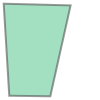

In [32]:
shape_geom_map = shape(get_in(["features", 0, "geometry"], geom_map))
shape_geom_map

The centroid is given by:

In [33]:
intersect_map_center = shape_geom_map.centroid
print(intersect_map_center)

POINT (-8.115254781697322 39.67809052275443)


Let us draw the map.

In [34]:
intersect_map = Map(center=(intersect_map_center.y, intersect_map_center.x), zoom=6)

# Add the AOI to the map. First style it and then add it.
intersect_layer = GeoJSON(
    data=geom_map,
    style={"opacity": 1, "dashArray": "9", "fillOpacity": 0.5, "weight": 1},
    hover_style={"color": "yellow", "dashArray": "0", "fillOpacity": 0.5},
)
# Add a marker layer at the center.
intersect_marker_layer = Marker(location=(intersect_map_center.y, intersect_map_center.x),
                                draggable=False, icon=AwesomeIcon(name="close",
                                                                  color_marker="green"))
intersect_map.add_layer(intersect_layer)
intersect_map.add_layer(intersect_marker_layer)
intersect_map

Map(center=[39.67809052275443, -8.115254781697322], controls=(ZoomControl(options=['position', 'zoom_in_text',…

This is the geometry for which we want to look for intersecting assets.
We can start to build the request body dictionary. We need to get the
shapely geometry to be a simple dictionary and not a shapely type.

In [35]:
type(shape_geom_map)

shapely.geometry.polygon.Polygon

In [36]:
intersect_req_body = dict(intersects = mapping(shape_geom_map))
intersect_req_body

{'intersects': {'type': 'Polygon',
  'coordinates': (((-9.52171458613654, 36.853921776429516),
    (-7.1631974367996065, 36.82161569679076),
    (-5.996066469639629, 42.04883107989275),
    (-9.841226786721336, 42.14603469432703),
    (-9.52171458613654, 36.853921776429516)),)}}

Now is the time to add the CQL2 filter. This is always something of the
form: `<filter> <operator> <args>`. The arguments can be composed of
other operators and args. In our case we want to limit all results to be
with a cloud cover less than 10%. In its simplest form the arguments are
logical clauses that must be satisfied. These clauses can be represented
in JSON as an array of operands and operators. In this case, concretely:

In [37]:
my_cloud_cover_dict = dict(filter=dict(args=[
    dict(property="eo:cloud_cover"), 10],
    op="<"))
my_cloud_cover_dict

{'filter': {'args': [{'property': 'eo:cloud_cover'}, 10], 'op': '<'}}

The structure of CQL2 is basically a [syntax
tree](https://en.wikipedia.org/wiki/Abstract_syntax_tree) with the nodes
being the operators and the root being the node `filter`.

Now we can update the request body with this filter.

In [38]:
new_intersect_req_body = intersect_req_body | my_cloud_cover_dict
new_intersect_req_body

{'intersects': {'type': 'Polygon',
  'coordinates': (((-9.52171458613654, 36.853921776429516),
    (-7.1631974367996065, 36.82161569679076),
    (-5.996066469639629, 42.04883107989275),
    (-9.841226786721336, 42.14603469432703),
    (-9.52171458613654, 36.853921776429516)),)},
 'filter': {'args': [{'property': 'eo:cloud_cover'}, 10], 'op': '<'}}

We can now perform the search:

In [39]:
complex_search_results = search_item(new_intersect_req_body).json()
ppjson(complex_search_results)

<IPython.core.display.JSON object>

We have more than 10 results, since I want to have only the ones in my
workspace I need to add my workspace as a CQL2 filter to the request.

In [40]:
cloud_cover_workspace_dict = dict(filter=
     dict(args=[
             dict(args=[dict(property="eo:cloud_cover"), 10],
                  op="<"),
             dict(args=[dict(property="workspace_id"), api_credentials['workspace_id']],
                  op="=")],
          op="and")
    )
cloud_cover_workspace_dict

{'filter': {'args': [{'args': [{'property': 'eo:cloud_cover'}, 10], 'op': '<'},
   {'args': [{'property': 'workspace_id'},
     'd39fe05a-400c-44f6-b770-86990f64b004'],
    'op': '='}],
  'op': 'and'}}

Performing the search with the two filters (cloud cover and workspace
ID):

In [41]:
complex_search_results = search_item(intersect_req_body | cloud_cover_workspace_dict).json()
ppjson(complex_search_results)

<IPython.core.display.JSON object>

We have 7 results. Let us try to visualize the returned items on the
map. We see that this is exactly the AOI we have above in
@map-collection-point.

In [42]:
complex_search_results_layer = GeoJSON(data=complex_search_results,
                                       style={"color":"red",  "opacity": 1,
                                              "dashArray": "9", "fillOpacity": 0.5,
                                              "weight": 1},
    hover_style={"color": "white", "dashArray": "0", "fillOpacity": 0.5},
)
intersect_map.add_layer(complex_search_results_layer)
intersect_map

Map(center=[39.67809052275443, -8.115254781697322], controls=(ZoomControl(options=['position', 'zoom_in_text',…

The features returned are too small to be easily detected without
panning & zooming. To make it clearer we are going to recenter the map
on the point of interest we introduced above and display only the
returned features.

In [43]:
complex_search_results_map = Map(center=my_first_map_center, zoom=12)
complex_search_results_map.add_layer(complex_search_results_layer)
complex_search_results_map

Map(center=[38.469947, -8.98691], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

We can see clearly the returned features in this area.

## Downloading the assets

We can easily extract the assets ID for downloading.

In [44]:
complex_search_asset_ids = list(map(lambda e: get_in(["properties", "up42-system:asset_id"], e),
                                    complex_search_results["features"]))
complex_search_asset_ids

['630bd8cd-c4c2-4619-9a88-5b3421ffd1de',
 '828b2da8-b322-4e19-9abc-3917e0e36986',
 'f5080d5d-cb90-4cb5-9caf-b1e870865967',
 'fa438b5e-0903-4787-8958-45a376dd9b04',
 '666191ca-0f28-4f49-9bae-597865187eb1',
 '696f6b22-523a-4f57-a6a3-16efa5b1edb5',
 '55dfa9f4-361f-44dd-b4c4-f1f05ad02cd3']

Let us create a convenience function for downloading the assets.

In [45]:
def download_asset(asset_id:str) -> None:
    """Downloads an asset with the given ID."""
    with open(f"asset_{asset_id}.zip", 'wb') as output:
        with httpx.stream("GET",
                          f"https://api.up42.com/v2/assets/{asset_id}",
                          auth=client_auth) as r:
            for data in r.iter_bytes():
                output.write(data)

We can iterate on the list of asset IDs.

In [46]:
gen_assets = (download_asset(id) for id in complex_search_asset_ids)

Uncomment the line below to download all assets listed above.

In [47]:
# list(gen_assets)

## Conclusions

STAC offers a very efficient and natural way to search catalogs of
geospatial assets. The current implementation on top of the UP42 storage
provides a large degree of flexibility, making it easy to access assets
using a multitude of search options. All assets are provided as
hypermedia, making it very simple to manipulate.

Go ahead and try the UP42 Spatial Asset Service API.